- One project idea for this Friday would be to compare all the different versions of the bible, see how they compare on sentiment, etc.--pulling via BeautifulSoup from this website:
http://www.biblestudytools.com/bible-versions/. But this is a more academic project in nature; something that could be published as an article of the form "what can natural language processing have to say about religion?" type of deal. 'computational theology', i.e. (is there such a thing as computational theology? if so, what could it look like?) -- this would be a good quick side project ;)

- Another direction will be semantic analysis. Ultimately the more profitable way to go. Just stick with the single text for now, stick it into gensim, see what comes of it. Will probs involve PCA.

- Another direction will be PCA --> Kmeans/K++ clustering.

In [7]:
# from pymongo import MongoClient
# import pymongo

# import numpy as np
# import pandas as pd
# import nltk
# from collections import defaultdict
# import unicodedata 
# import string 
# #import soundex #-->requires repoze.lru??
# #from nltk.tokenize import sent_tokenize
# #from nltk.tokenize import TreebankWordTokenizer
# from tqdm import tqdm
# import re
# import pickle

In [428]:
#NLpre-P
import re
import pymongo
from tqdm import tqdm
import pickle
import pandas as pd

#NLP
import nltk
from nltk.tag import pos_tag
from textblob import TextBlob
from gensim import corpora, models, similarities
import logging

In [9]:
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import pymongo

client = pymongo.MongoClient()
geist = client.geist_db
bible = client.geist_db.bible_collection

#bible.drop() # Clear out any data we had in the collection.

for review in reviews:
    hmm.save(review)
'''

###0. get data from pgiso ... this will come
for now, just starting with a single example...

. csvs --> mongo (still have to add the 'to mongo' part)  (would be nice but for now...)

###1. get documents

In [156]:
def get_docs(filename, form='gutenberg'):
    '''Converts a file into documents. Documents are separated by blank lines in the file.'''
    
    f = open(filename)
    startline = 100
    endline = 1000000
    documents = []
    document = ''    
    if form == 'gutenberg':
        start = "*** START OF THIS PROJECT GUTENBERG EBOOK"
        end = "*** END OF THIS PROJECT GUTENBERG EBOOK"

    for i, line in enumerate(f):
        if start in line:
            startline = i
        if end in line:
            endline = i
        if i > startline and i < endline:
            #Beginning of Document
            if line.strip():  
                document += line[:-2]
            #End of Document
            else: 
                if document != '' and isinstance(document, str):
                    for word in document:
                        if word in stopwords:
                            document.replace(word, '')
                    documents.append(document)
                    document = ''
    f.close()
    return documents

In [124]:
docs_bible = get_docs('bible.txt')

In [129]:
docs_bible[:10]

['The Old Testament of the King James Version of the Bible',
 'The First Book of Moses:  Called Genesis',
 '1:1 In the beginning God created the heaven and the earth.',
 '1:2 And the earth was without form, and void; and darkness was uponthe face of the deep. And the Spirit of God moved upon the face of thewaters.',
 '1:3 And God said, Let there be light: and there was light.',
 '1:4 And God saw the light, that it was good: and God divided the lightfrom the darkness.',
 '1:5 And God called the light Day, and the darkness he called Night.And the evening and the morning were the first day.',
 '1:6 And God said, Let there be a firmament in the midst of the waters,and let it divide the waters from the waters.',
 '1:7 And God made the firmament, and divided the waters which wereunder the firmament from the waters which were above the firmament:and it was so.',
 '1:8 And God called the firmament Heaven. And the evening and themorning were the second day.']

#1. alla the bibles

In [223]:
versions = {  #27
'American Standard Version':'ASV',
'English Standard Version':'ESV',
'GOD\'S WORD Translation':'GW',
'Good News Translation':'GNT',
'Holman Christian Standard Bible':'CSB',
'Jubilee Bible 2000':'JUB',
'King James Version':'KJV',
'Lexham English Bible':'LEB',
'Douay-Rhiems Catholic Bible':'RHE',
'New American Standard Bible':'NAS',
'New International Version':'NIV',
'New King James Version':'NKJV',
'New Living Translation':'NLT',
'New Revised Standard':'NRS',
'Revised Standard Version':'RSV',
'The Message Bible':'MSG',
'Hebrew Names Version':'HNV',
'New Century Version':'NCV',
'New International Reader\'s Version':'NIRV',
'The Bible in Basic English':'BBE',
'The Complete Jewish Bible':'CJB',
'Third Millennium Bible':'TMB',
'World English Bible':'WEB',
'Young\'s Literal Translation':'YLT',
'The Darby Translation':'DBY',
'The Webster Bible':'WBT',
'Wycliffe':'WYC'
}

In [228]:
with open("bibles_data_1.pkl", 'r') as picklefile: 
    bibles_data_1 = pickle.load(picklefile)
with open("bibles_data_2.pkl", 'r') as picklefile: 
    bibles_data_2 = pickle.load(picklefile)
with open("bibles_data_3.pkl", 'r') as picklefile: 
    bibles_data_3 = pickle.load(picklefile)
with open("bibles_data_4.pkl", 'r') as picklefile: 
    bibles_data_4 = pickle.load(picklefile)
with open("bibles_data_5.pkl", 'r') as picklefile: 
    bibles_data_5 = pickle.load(picklefile)
with open("bibles_data_6.pkl", 'r') as picklefile: 
    bibles_data_6 = pickle.load(picklefile)
with open("bibles_data_7.pkl", 'r') as picklefile: 
    bibles_data_7 = pickle.load(picklefile)

In [436]:
#the ones with the metadata

with open("bibles_w_metadata_1.pkl", 'r') as picklefile: 
    bibles_data_metadata_1 = pickle.load(picklefile)
with open("bibles_w_metadata_2.pkl", 'r') as picklefile: 
    bibles_data_metadata_2 = pickle.load(picklefile)
with open("bibles_w_metadata_3.pkl", 'r') as picklefile: 
    bibles_data_metadata_3 = pickle.load(picklefile)
with open("bibles_w_metadata_4.pkl", 'r') as picklefile: 
    bibles_data_metadata_4 = pickle.load(picklefile)
with open("bibles_w_metadata_5.pkl", 'r') as picklefile: 
    bibles_data_metadata_5 = pickle.load(picklefile)
with open("bibles_w_metadata_6.pkl", 'r') as picklefile: 
    bibles_data_metadata_6 = pickle.load(picklefile)

In [437]:
bibles_data_metadata = [bibles_data_metadata_1, bibles_data_metadata_2, 
                        bibles_data_metadata_3, bibles_data_metadata_4, 
                        bibles_data_metadata_5, bibles_data_metadata_6]

In [229]:
bibles_data = [bibles_data_1, bibles_data_2, bibles_data_3, bibles_data_4,
              bibles_data_5, bibles_data_6, bibles_data_7]

In [227]:
client = pymongo.MongoClient()
bibles = client.legislation

In [232]:
#in mongo -- probs need to be more organized to use this-- 
# would be good at a more granular level?

for b in bibles_data:
    for name, docs in b.items():
        versions[name] = bibles.versions[name]
        for i, document in tqdm(enumerate(docs)):
            versions[name].save({str(i): document})

In [234]:
bibles_df = pd.DataFrame()
for b in bibles_data:
    for name, docs in b.items():
        bibles_df[name] = docs

In [442]:
bibles_metadata_df = pd.DataFrame()
for b in bibles_data_metadata:
    for name, docs_dict in b.items():
        docs = []
        indices = []
        for book_chap_key, doc in docs_dict.items():
            docs.append(doc)
            indices.append(book_chap_key)
        bibles_metadata_df[name] = docs

In [462]:
bibles_metadata_df.index = indices

In [467]:
genesis_df = bibles_metadata_df
for index, row in bibles_metadata_df.iterrows():
    if index[0] != 'Genesis':
        genesis_df = genesis_df.drop(index)

In [469]:
len(genesis_df)

50

In [466]:
df_new = bibles_metadata_df.reset_index()
df_new.head()



# df = df.reset_index

,index,American Standard Version,Good News Translation,Holman Christian Standard Bible,GOD'S WORD Translation,Jubilee Bible 2000,Lexham English Bible,King James Version,Douay-Rhiems Catholic Bible,New King James Version,...,Hebrew Names Version,The Message Bible,World English Bible,Third Millennium Bible,The Bible in Basic English,The Complete Jewish Bible,The Webster Bible,Young's Literal Translation,Wycliffe,The Darby Translation
0,"(Psalms, 52)",Why boaste...,Why do you...,God Judges the ProudFor the choir director A D...,Why do you...,Why dost t...,For the music director A maskil of David When ...,Why boaste...,Unto the ...,To the Chi...,...,Why do yo...,Why do you...,Why do yo...,Why boast...,Purposing ...,For the le...,To the chi...,To the Ove...,To victory...,To the chi...
1,"(Habakkuk, 3)",A prayer o...,This is a ...,Habakkuks Third Prayer ...,A prayer o...,A prayer of Habakkuk the prophet because of al...,The Prayer of Habakkuk ...,A prayer o...,A PRAYER O...,A prayer o...,...,A prayer o...,A prayer o...,A prayer o...,A prayer o...,A prayer o...,This is a ...,A prayer o...,A prayer o...,The prayer...,A Prayer o...
2,"(1-Chronicles, 29)",And David ...,King David...,Contributions for Building the Temple ...,Then King ...,Furthermor...,Offerings for the Temple ...,Furthermor...,And king D...,Furthermor...,...,David the ...,Then David...,David the ...,Furthermor...,And David ...,To the who...,Furthermor...,And David ...,And king D...,And king D...
3,"(Revelation, 1)",The Revela...,This book ...,Prologue Th...,This is th...,The Revela...,Prologue Th...,The Revela...,The Revela...,The Revela...,...,This is th...,A revealin...,This is th...,The Revela...,The Revela...,This is th...,The Revela...,A revelati...,Apocalypse...,Revelation...
4,"(Deuteronomy, 17)",Thou shalt...,Do not sac...,You must n...,Never offe...,Thou shalt...,You shall ...,Thou shalt...,Thou shalt...,You shall ...,...,You shall ...,And dont s...,You shall ...,Thou shalt...,No ox or s...,You are no...,Thou shalt...,Thou dost ...,Thou shalt...,Thou shalt...


In [464]:
version_names_metadata = cleaned_bibles_df.columns.tolist()

###### allathabibles -- with metadata indices -- ######

count_vectorized_bibles_w_metadata = {}
for name in tqdm(version_names_metadata):
    vectorizer = CountVectorizer(stop_words=archaic_stopwords, 
                             token_pattern='[A-Za-z]+', min_df=2)
    single_bible_corpus = bibles_metadata_df[name]
    print name
    vectorized = vectorizer.fit_transform(single_bible_corpus)
    count_vectorized_bibles_w_metadata[name] = (vectorizer, vectorized)

  4%|▍         | 1/24 [00:04<01:44,  4.55s/it]

American Standard Version
Good News Translation

  8%|▊         | 2/24 [00:07<01:28,  4.02s/it]


Holman Christian Standard Bible

 12%|█▎        | 3/24 [00:10<01:20,  3.83s/it]


GOD'S WORD Translation

 17%|█▋        | 4/24 [00:13<01:08,  3.40s/it]


Jubilee Bible 2000

 21%|██        | 5/24 [00:15<00:59,  3.14s/it]


Lexham English Bible

 25%|██▌       | 6/24 [00:19<00:59,  3.31s/it]


King James Version

 29%|██▉       | 7/24 [00:22<00:53,  3.15s/it]


Douay-Rhiems Catholic Bible

 33%|███▎      | 8/24 [00:24<00:47,  2.95s/it]


New King James Version

 38%|███▊      | 9/24 [00:27<00:42,  2.83s/it]


New Living Translation

 42%|████▏     | 10/24 [00:29<00:38,  2.78s/it]


The Message Bible

 46%|████▌     | 11/24 [00:32<00:34,  2.68s/it]


Hebrew Names Version

 50%|█████     | 12/24 [00:34<00:31,  2.59s/it]


New Revised Standard

 54%|█████▍    | 13/24 [00:37<00:28,  2.60s/it]


Revised Standard Version

 58%|█████▊    | 14/24 [00:39<00:25,  2.52s/it]


The Complete Jewish Bible

 62%|██████▎   | 15/24 [00:42<00:22,  2.50s/it]


The Bible in Basic English

 67%|██████▋   | 16/24 [00:44<00:19,  2.50s/it]


New Century Version

 71%|███████   | 17/24 [00:46<00:17,  2.48s/it]


New International Reader's Version

 75%|███████▌  | 18/24 [00:49<00:15,  2.57s/it]


World English Bible

 79%|███████▉  | 19/24 [00:52<00:12,  2.50s/it]


Young's Literal Translation

 83%|████████▎ | 20/24 [00:54<00:09,  2.50s/it]


Third Millennium Bible

 88%|████████▊ | 21/24 [00:57<00:07,  2.50s/it]


The Webster Bible

 92%|█████████▏| 22/24 [00:59<00:04,  2.49s/it]


Wycliffe

 96%|█████████▌| 23/24 [01:03<00:03,  3.01s/it]


The Darby Translation

In [463]:
bibles_metadata_df.head()

,American Standard Version,Good News Translation,Holman Christian Standard Bible,GOD'S WORD Translation,Jubilee Bible 2000,Lexham English Bible,King James Version,Douay-Rhiems Catholic Bible,New King James Version,New Revised Standard,...,Hebrew Names Version,The Message Bible,World English Bible,Third Millennium Bible,The Bible in Basic English,The Complete Jewish Bible,The Webster Bible,Young's Literal Translation,Wycliffe,The Darby Translation
"(Psalms, 52)",Why boaste...,Why do you...,God Judges the ProudFor the choir director A D...,Why do you...,Why dost t...,For the music director A maskil of David When ...,Why boaste...,Unto the ...,To the Chi...,Why do you...,...,Why do yo...,Why do you...,Why do yo...,Why boast...,Purposing ...,For the le...,To the chi...,To the Ove...,To victory...,To the chi...
"(Habakkuk, 3)",A prayer o...,This is a ...,Habakkuks Third Prayer ...,A prayer o...,A prayer of Habakkuk the prophet because of al...,The Prayer of Habakkuk ...,A prayer o...,A PRAYER O...,A prayer o...,A prayer o...,...,A prayer o...,A prayer o...,A prayer o...,A prayer o...,A prayer o...,This is a ...,A prayer o...,A prayer o...,The prayer...,A Prayer o...
"(1-Chronicles, 29)",And David ...,King David...,Contributions for Building the Temple ...,Then King ...,Furthermor...,Offerings for the Temple ...,Furthermor...,And king D...,Furthermor...,King David...,...,David the ...,Then David...,David the ...,Furthermor...,And David ...,To the who...,Furthermor...,And David ...,And king D...,And king D...
"(Revelation, 1)",The Revela...,This book ...,Prologue Th...,This is th...,The Revela...,Prologue Th...,The Revela...,The Revela...,The Revela...,The revela...,...,This is th...,A revealin...,This is th...,The Revela...,The Revela...,This is th...,The Revela...,A revelati...,Apocalypse...,Revelation...
"(Deuteronomy, 17)",Thou shalt...,Do not sac...,You must n...,Never offe...,Thou shalt...,You shall ...,Thou shalt...,Thou shalt...,You shall ...,You must n...,...,You shall ...,And dont s...,You shall ...,Thou shalt...,No ox or s...,You are no...,Thou shalt...,Thou dost ...,Thou shalt...,Thou shalt...


In [235]:
bibles_df.head()   
#yaaaaaaas (ideally the indices would be labels buuuut...fuqdat)

,American Standard Version,Good News Translation,English Standard Version,Holman Christian Standard Bible,GOD'S WORD Translation,Jubilee Bible 2000,Lexham English Bible,King James Version,Douay-Rhiems Catholic Bible,New King James Version,...,The Complete Jewish Bible,The Bible in Basic English,New Century Version,New International Reader's Version,World English Bible,Young's Literal Translation,Third Millennium Bible,The Webster Bible,Wycliffe,The Darby Translation
0,Paul calle...,From Paul ...,Greeting Pa...,Greeting Pa...,From Paul ...,Paul calle...,Greeting Pa...,Paul called to be an apostle of Jesus Christ t...,Paul calle...,Paul calle...,...,From Shaul...,Paul an Ap...,From Paul ...,I Paul am ...,Paul calle...,Paul a cal...,Paul calle...,Paul calle...,Paul calle...,Paul a cal...
1,And I bret...,When I cam...,Proclaiming Christ Crucified ...,Pauls Proclamation ...,Brothers a...,And I brot...,Pauls Approach to Ministry in Corinth ...,And I bret...,And I bret...,And I bret...,...,As for me ...,And when I...,Dear broth...,Brothers a...,When I cam...,And I havi...,And I bret...,And I bret...,And I bret...,And I when...
2,And I bret...,As a matte...,Divisions in the Church ...,The Problem of Immaturity ...,Brothers a...,And I brot...,Divisiveness and Immaturity ...,And I brethren could not speak unto you as un...,And I bret...,And I bret...,...,As for me ...,And the te...,Brothers a...,Taking Sides in the Church ...,Brothers I...,And I bret...,And I bret...,And I bret...,And I bret...,And I bret...
3,Let a man ...,You should...,The Ministry of Apostles ...,The Faithful Manager ...,People sho...,Let us rec...,Christs Servant Gods Steward ...,Let a man so account of us as of the ministe...,Let a man ...,Let a man ...,...,So you sho...,Let us be ...,People sho...,Apostles of Christ ...,So let a m...,Let a man ...,Let a man ...,Let a man ...,So a man g...,Let a man ...
4,It is actu...,Now it is ...,Sexual Immorality Defiles the Church ...,Immoral Church Members ...,Your own m...,It is repo...,Immoral Behavior and Church Discipline ...,It is repo...,It is abso...,It is actu...,...,It is actu...,It is said...,It is actu...,Throw the Evil Person Out ...,It is actu...,Whoredom i...,It is repo...,It is repo...,Yet all ma...,It is univ...


In [392]:
len(bibles_df)

1189

In [318]:
cleaned_bibles_df = bibles_df.drop(
    'New International Version', axis=1).drop(
    'English Standard Version', axis=1).drop(
    'New American Standard Bible', axis=1)

In [315]:
print versions.keys()
# 'New International Version' == fucked up
# 'Hebrew Names Version'
# 'Good News Translation'
# "GOD'S WORD Translation"
# 'King James Version'
# 'The Darby Translation'
# 'The Webster Bible'
# 'Wycliffe'
# 'The Bible in Basic English'
# 'World English Bible'
# 'Douay-Rhiems Catholic Bible'
# 'Lexham English Bible' == lil bit fucked; 'references', 'footnotes'
# 'New Living Translation'
# 'Revised Standard Version'
# 'New Century Version'
# "New International Reader's Version"
# 'Jubilee Bible 2000'
# 'English Standard Version' == fucked
# 'New American Standard Bible' == fucked
# 'American Standard Version'
# 'Holman Christian Standard Bible' ==lil bit fucked; 'references', 'footnotes'
# 'New Revised Standard'==lil bit fucked; 'references', 'footnotes'
# "Young's Literal Translation"
# 'The Complete Jewish Bible'
# 'The Message Bible'
# 'New King James Version'
# 'Third Millennium Bible'

['New International Version', 'Hebrew Names Version', 'Good News Translation', "GOD'S WORD Translation", 'King James Version', 'The Darby Translation', 'The Webster Bible', 'Wycliffe', 'The Bible in Basic English', 'World English Bible', 'Douay-Rhiems Catholic Bible', 'Lexham English Bible', 'New Living Translation', 'Revised Standard Version', 'New Century Version', "New International Reader's Version", 'Jubilee Bible 2000', 'English Standard Version', 'New American Standard Bible', 'American Standard Version', 'Holman Christian Standard Bible', 'New Revised Standard', "Young's Literal Translation", 'The Complete Jewish Bible', 'The Message Bible', 'New King James Version', 'Third Millennium Bible']


In [316]:
# for name in versions.keys(): 
#     print name
#     print bibles_df[name][22]
#     print '\n\n\n'

#2. CountVectorize that shit

In [236]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [ ]:
'NN': 'noun, singular or mass---door',
'NNS': 'noun plural---doors',
'NNP': 'proper noun, singular---John',
'NNPS': 'proper noun, plural---Vikings',

1.
- filter out all but NN and NNS
- filter out all but NNP and NNPS
- then do topic modeling based on these.


2. 
- see diana's notebook for lda viz

3.
- clustering w/ jaccard distance


In [470]:
archaic_stopwords = nltk.corpus.stopwords.words('english') + [u'shall', u'shant', u'ye', 
                                                              u'thy', u'thou', u'thee', 
                                                              u'thine', u'said', u'hast', 
                                                              u'hath', u'unto', u'upon',
                                                              u'references', u'footnotes',
                                                              u'came', u'come', u'went',
                                                              u'heb', u'made', u'make',
                                                              u'doth', u'saith']

In [173]:
##single bible from gutenberg
vectorizer = CountVectorizer(stop_words=archaic_stopwords, 
                             token_pattern='[A-Za-z]+', min_df=2)
vecs_bible = vectorizer.fit_transform(docs_bible)

####Here's w/ all the bibles:

In [319]:
version_names = cleaned_bibles_df.columns.tolist()

In [321]:
len(version_names)

24

In [365]:
import timeit

In [368]:
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
words = word_tokenize("Who's going to that thing today?")
pos_tag(['who'])

[('who', 'WP')]

In [372]:
blob = TextBlob('apple orange banana, cynthia one, cynthia two')
blob.tags

[('apple', u'NN'),
 ('orange', u'NN'),
 ('banana', u'NN'),
 ('cynthia', u'VB'),
 ('one', u'CD'),
 ('cynthia', u'VBZ'),
 ('two', u'CD')]

In [373]:
bibles_nouns = {}
#bibles_proper_nouns = {}
for name in version_names:
    print name
    corpus = []
    for doc in tqdm(cleaned_bibles_df[name]):
        for word, pos in TextBlob(doc).tags:
            if pos != u'NN' and pos != u'NNS':
                doc.replace(word, '')
        corpus.append(doc)
    bibles_nouns[name] = corpus

 23%|██▎       | 276/1189 [09:42<32:07,  2.11s/it]

American Standard Version


KeyboardInterrupt: 

In [471]:
#####genesis_all_bibles (scrapedstuff)######

cv_genesis = {}
for name in tqdm(version_names):
    vectorizer = CountVectorizer(stop_words=archaic_stopwords, 
                             token_pattern='[A-Za-z]+', min_df=2)
    single_bible_corpus = genesis_df[name]
    print name
    vectorized = vectorizer.fit_transform(single_bible_corpus)
    cv_genesis[name] = (vectorizer, vectorized)

  4%|▍         | 1/24 [00:00<00:03,  6.65it/s]

American Standard Version
Good News Translation

  8%|▊         | 2/24 [00:00<00:03,  7.06it/s]


Holman Christian Standard Bible

 12%|█▎        | 3/24 [00:00<00:03,  6.48it/s]


GOD'S WORD Translation

 17%|█▋        | 4/24 [00:00<00:02,  6.90it/s]


Jubilee Bible 2000

 21%|██        | 5/24 [00:00<00:02,  6.72it/s]


Lexham English Bible

 25%|██▌       | 6/24 [00:00<00:02,  6.37it/s]


King James Version

 29%|██▉       | 7/24 [00:01<00:02,  6.40it/s]


Douay-Rhiems Catholic Bible

 33%|███▎      | 8/24 [00:01<00:02,  6.82it/s]


New King James Version

 38%|███▊      | 9/24 [00:01<00:02,  6.82it/s]


New Living Translation

 42%|████▏     | 10/24 [00:01<00:02,  6.66it/s]


The Message Bible

 46%|████▌     | 11/24 [00:01<00:01,  7.14it/s]


Hebrew Names Version

 50%|█████     | 12/24 [00:01<00:01,  7.41it/s]


New Revised Standard

 54%|█████▍    | 13/24 [00:01<00:01,  7.41it/s]


Revised Standard Version

 58%|█████▊    | 14/24 [00:02<00:01,  7.41it/s]


The Complete Jewish Bible

 62%|██████▎   | 15/24 [00:02<00:01,  7.53it/s]


The Bible in Basic English

 67%|██████▋   | 16/24 [00:02<00:01,  7.58it/s]


New Century Version

 71%|███████   | 17/24 [00:02<00:00,  7.56it/s]


New International Reader's Version

 75%|███████▌  | 18/24 [00:02<00:00,  6.73it/s]


World English Bible

 79%|███████▉  | 19/24 [00:02<00:00,  7.18it/s]


Young's Literal Translation

 83%|████████▎ | 20/24 [00:02<00:00,  7.36it/s]


Third Millennium Bible

 88%|████████▊ | 21/24 [00:02<00:00,  7.51it/s]


The Webster Bible

 92%|█████████▏| 22/24 [00:03<00:00,  7.55it/s]


Wycliffe

 96%|█████████▌| 23/24 [00:03<00:00,  6.31it/s]


The Darby Translation

In [424]:
######allathabibles (scrapedstuff)######

count_vectorized_bibles = {}
for name in tqdm(version_names):
    vectorizer = CountVectorizer(stop_words=archaic_stopwords, 
                             token_pattern='[A-Za-z]+', min_df=2)
    single_bible_corpus = cleaned_bibles_df[name]
    print name
    vectorized = vectorizer.fit_transform(single_bible_corpus)
    count_vectorized_bibles[name] = (vectorizer, vectorized)

  4%|▍         | 1/24 [00:02<01:02,  2.73s/it]

American Standard Version
Good News Translation

  8%|▊         | 2/24 [00:05<00:59,  2.72s/it]


Holman Christian Standard Bible

 12%|█▎        | 3/24 [00:08<00:59,  2.82s/it]


GOD'S WORD Translation

 17%|█▋        | 4/24 [00:11<00:55,  2.78s/it]


Jubilee Bible 2000

 21%|██        | 5/24 [00:14<00:53,  2.84s/it]


Lexham English Bible

 25%|██▌       | 6/24 [00:18<00:57,  3.22s/it]


King James Version

 29%|██▉       | 7/24 [00:21<00:54,  3.22s/it]


Douay-Rhiems Catholic Bible

 33%|███▎      | 8/24 [00:24<00:49,  3.09s/it]


New King James Version

 38%|███▊      | 9/24 [00:27<00:45,  3.06s/it]


New Living Translation

 42%|████▏     | 10/24 [00:30<00:42,  3.05s/it]


The Message Bible

 46%|████▌     | 11/24 [00:33<00:39,  3.01s/it]


Hebrew Names Version

 50%|█████     | 12/24 [00:35<00:34,  2.89s/it]


New Revised Standard

 54%|█████▍    | 13/24 [00:38<00:31,  2.88s/it]


Revised Standard Version

 58%|█████▊    | 14/24 [00:41<00:28,  2.83s/it]


The Complete Jewish Bible

 62%|██████▎   | 15/24 [00:44<00:25,  2.84s/it]


The Bible in Basic English

 67%|██████▋   | 16/24 [00:47<00:23,  2.92s/it]


New Century Version

 71%|███████   | 17/24 [00:49<00:19,  2.83s/it]


New International Reader's Version

 75%|███████▌  | 18/24 [00:52<00:17,  2.87s/it]


World English Bible

 79%|███████▉  | 19/24 [00:55<00:14,  2.82s/it]


Young's Literal Translation

 83%|████████▎ | 20/24 [00:58<00:10,  2.75s/it]


Third Millennium Bible

 88%|████████▊ | 21/24 [01:00<00:08,  2.76s/it]


The Webster Bible

 92%|█████████▏| 22/24 [01:03<00:05,  2.77s/it]


Wycliffe

 96%|█████████▌| 23/24 [01:08<00:03,  3.32s/it]


The Darby Translation

In [416]:
ylt_vectorizer = CountVectorizer(stop_words=archaic_stopwords, 
                             token_pattern='[A-Za-z]+', min_df=2)
ylt_corpus = cleaned_bibles_df['Young\'s Literal Translation']
ylt_vectorized = ylt_vectorizer.fit_transform(ylt_corpus)
count_vectorized_bibles['Young\'s Literal Translation'] = (ylt_vectorizer, ylt_vectorized)

In [342]:
# with open('count_vectorized_bibles.pkl', 'w') as picklefile:
#     pickle.dump(count_vectorized_bibles, picklefile)

In [265]:
count_vectorized_bibles['New International Version']

<1189x10364 sparse matrix of type '<type 'numpy.int64'>'
	with 226272 stored elements in Compressed Sparse Row format>

In [376]:
counts_dfs = {}
for name, values in count_vectorized_bibles.items():
    vecs_array = values[1].toarray()
    counts_df = pd.DataFrame(vecs_array, columns=values[0].get_feature_names())
    counts_dfs[name] = counts_df
    

#First Really Interesting Thing: 
interesting differences:!!

linguistic homologies: top words

In [379]:
#most popular words
for name, df in counts_dfs.items():
    freq = df.sum().reset_index()
    freq.columns = ['word', 'freq']
    freq = freq.sort(columns='freq', ascending=False)
    print name
    print freq.head()
    print '\n'

Hebrew Names Version
         word  freq
4113     lord  7814
2971      god  4277
8004  yisrael  2542
6522      son  2348
4228      man  2322


Good News Translation
        word  freq
4235    lord  6423
5143  people  5014
2994     god  4432
1578   cross  3549
4917     one  2789


GOD'S WORD Translation
        word  freq
4479    lord  6963
5429  people  4850
3130     god  4110
5179     one  2360
4208    king  2264


King James Version
        word  freq
4975    lord  7649
3476     god  4160
5109     man  2624
4307  israel  2476
7690     son  2341


The Darby Translation
         word  freq
4797  jehovah  6800
3834      god  4246
7791      see  2957
6182      one  2649
4706   israel  2599


The Webster Bible
        word  freq
4315    lord  7830
3062     god  4410
4430     man  2618
3748  israel  2566
6717     son  2358


Wycliffe
        word   freq
4937    lord  13815
3528     god   7366
5199     men   5422
8164  things   4788
5059     man   4681


The Bible in Basic English
      wor

/Users/Ben/anaconda/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [176]:
vecs_bible_array = vecs_bible.toarray()
counts_df = pd.DataFrame(vecs_bible_array, columns=vectorizer.get_feature_names())

In [182]:
counts_df[:1]

,aaron,aaronand,aaronites,aaronnumbered,aaronthe,abarim,abase,abased,abated,abba,...,zobah,zohar,zophah,zophar,zorah,zorobabel,zuar,zuph,zur,zurishaddai
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [177]:
word_freq = counts_df.sum().reset_index()
word_freq.columns = ['word', 'freq']

word_freq = word_freq.sort(columns='freq', ascending=False)
word_freq.head()

/Users/Ben/anaconda/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,word,freq
6601,lord,7222
4496,god,4096
6782,man,2500
6213,king,2304
5861,israel,2263


In [208]:
word_freq[:20]

,word,freq
6601,lord,7222
4496,god,4096
6782,man,2500
6213,king,2304
5861,israel,2263
10006,son,2209
4826,hath,1957
2133,came,1955
8203,people,1862
2443,come,1792


In [174]:
vectorizer.get_feature_names()

[u'aaron',
 u'aaronand',
 u'aaronites',
 u'aaronnumbered',
 u'aaronthe',
 u'abarim',
 u'abase',
 u'abased',
 u'abated',
 u'abba',
 u'abda',
 u'abdi',
 u'abdon',
 u'abednego',
 u'abel',
 u'abelbethmaachah',
 u'abelmeholah',
 u'abenjamite',
 u'abhor',
 u'abhorred',
 u'abhorrest',
 u'abhorreth',
 u'abia',
 u'abiah',
 u'abiathar',
 u'abiatharthe',
 u'abib',
 u'abidan',
 u'abide',
 u'abideth',
 u'abiding',
 u'abiel',
 u'abiezer',
 u'abigail',
 u'abihail',
 u'abihu',
 u'abijah',
 u'abijam',
 u'ability',
 u'abimelech',
 u'abinadab',
 u'abinoam',
 u'abiram',
 u'abishag',
 u'abishai',
 u'abishaihis',
 u'abishalom',
 u'abishua',
 u'abishur',
 u'abital',
 u'able',
 u'ablessing',
 u'ableto',
 u'abner',
 u'abode',
 u'abolished',
 u'abominable',
 u'abomination',
 u'abominations',
 u'abominationswhich',
 u'abond',
 u'abound',
 u'abounded',
 u'aboundeth',
 u'abounding',
 u'aboutfour',
 u'aboutthe',
 u'aboutthem',
 u'aboutto',
 u'aboutwith',
 u'aboveall',
 u'abovethe',
 u'abraham',
 u'abram',
 u'abrawl

In [251]:
# ######allathabibles (scrapedstuff)######  this gave an error
# vectorizer = CountVectorizer(stop_words=archaic_stopwords, 
#                              token_pattern='[A-Za-z]+', min_df=2)

# count_vectorized_bibles = {}
# for name in tqdm(versions.keys()):
#     single_bible_corpus = bibles_df.loc[:, name]
#     vectorized = vectorizer.fit_transform(single_bible_corpus)
#     vector_array = vectorized.toarray()
#     counts_df = pd.DataFrame(vecs_bible_array, columns=vectorizer.get_feature_names())
#     count_vectorized_bibles[name] = counts_df

#2a. tf-idf (see if this will make for better inertia)

In [ ]:
class sklearn.feature_extraction.text.TfidfVectorizer

do this for rows instead of columns?

#3. LDA topic modeling

In [252]:
import numpy as np
import lda

####allthebibles

In [381]:
range(1,6)

[1, 2, 3, 4, 5]

In [384]:
def lda_topic_model(matrix, numtopics=range(1,6)):
    topic_models = {}
    for n in numtopics:
        model = lda.LDA(n_topics=n, n_iter=100, random_state=1) #n_iter could be higher?
        model.fit_transform(matrix)
        topic_models[n] = model
    return topic_models

In [472]:
lda_genesis_models = {}
for name in tqdm(version_names):
    lda_model = lda_topic_model(cv_genesis[name][1])
    lda_genesis_models[name] = lda_model

In [473]:
with open('lda_genesis_models.pkl', 'w') as picklefile:
    pickle.dump(lda_genesis_models, picklefile)

In [478]:
genesis_topwords = {}
for name, models in lda_genesis_models.items():
    topwords = view_topics(models, cv_genesis[name][0])
    genesis_topwords[name] = topwords

In [503]:
genesis_topics = {}
for name, numtopics in genesis_topwords.items():
    topics = [t[9:] for t in numtopics[3]]
    genesis_topics[name] = ' '.join(topics)
    #print name 
    #print numtopics[3] 

#now, we're going to try to see how different these works really are

In [506]:
import numpy as np
from sklearn.metrics import jaccard_similarity_score

In [552]:
JankyAssMatrix = []
for name, text1 in genesis_topics.items():
    matrix_row = []
    text1 = text1.split()
    for name, text2 in genesis_topics.items():
        text2 = text2.split()
        j_score = jaccard_similarity_score(text1, text2)
        matrix_row.append(j_score)
    JankyAssMatrix.append(matrix_row)
JankyAssMatrix = np.matrix(JankyAssMatrix)

In [553]:
JankyAssMatrix

matrix([[ 1.        ,  0.        ,  0.02777778,  0.02777778,  0.02777778,
          0.11111111,  0.        ,  0.        ,  0.05555556,  0.02777778,
          0.02777778,  0.        ,  0.        ,  0.02777778,  0.        ,
          0.11111111,  0.05555556,  0.11111111,  0.05555556,  0.02777778,
          0.05555556,  0.02777778,  0.02777778,  0.05555556],
        [ 0.        ,  1.        ,  0.        ,  0.05555556,  0.02777778,
          0.05555556,  0.02777778,  0.        ,  0.02777778,  0.02777778,
          0.05555556,  0.02777778,  0.02777778,  0.11111111,  0.05555556,
          0.        ,  0.05555556,  0.        ,  0.02777778,  0.        ,
          0.        ,  0.        ,  0.05555556,  0.11111111],
        [ 0.02777778,  0.        ,  1.        ,  0.02777778,  0.        ,
          0.        ,  0.        ,  0.05555556,  0.        ,  0.02777778,
          0.02777778,  0.02777778,  0.02777778,  0.        ,  0.02777778,
          0.02777778,  0.02777778,  0.        ,  0.02777778,  

## taking a straight jaccard distance, the similarities seem low
Conclusion: the order of those words are not similar...????

In [509]:
#print JankyAssMatrix

In [510]:

# y_pred = ['a', 'b', 'b', 'b']
# y_true = ['a', 'b', 'a', 'b']
# jaccard_similarity_score(y_true, y_pred)

#####but we can put it in a model too, circles


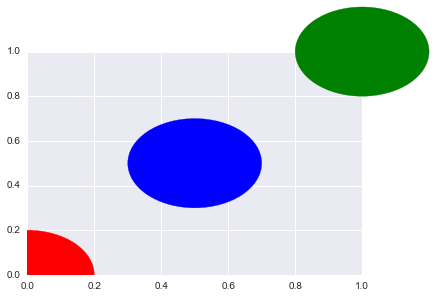

In [511]:
import matplotlib.pyplot as plt
circle1=plt.Circle((0,0),.2,color='r')
circle2=plt.Circle((.5,.5),.2,color='b')
circle3=plt.Circle((1,1),.2,color='g',clip_on=False)
fig = plt.gcf()
fig.gca().add_artist(circle1)
fig.gca().add_artist(circle2)
fig.gca().add_artist(circle3)
fig.savefig('plotcircles.png')

In [ ]:
#ron's contractions
dcontractions = {"she'll": ' she will', "you'd": ' you had', "don't": ' do not', "didn't": ' did not', 'yall': ' you all', "they've": ' they have', "won't": ' will not', "we'd": ' we had', "couldn't": ' could not', "shan't": ' shall not', "doesn't": ' does not', "he's": ' he is', "it's": ' it is', "where's": ' where is', "he'd": ' he had', "there's": ' there is', "shouldn't": ' should not', "they'll": ' they will', "haven't": ' have not', "we're": ' we are', "who've": ' who have', "mightn't": ' might not', "what're": ' what are', "mustn't ": ' must not', "you're": ' you are', "what's": ' what is', "who's": ' who is', "let's": ' let us', "they'd": ' they had', "what'll": ' what will', "I'd": ' I had', "you've": ' you have', "what've": ' what have', "hadn't": ' had not', "who'll": ' who will', "I'm": ' I am', "aren't": ' are not', "who'd": ' who had', "he'll": ' he will', "I'll": ' I will', "they're": ' they are', "weren't": ' were not', "wouldn't": ' would not', "I've": ' I have', "hasn't": ' has not', "she'd": ' she had', "you'll": ' you will', "can't": ' cannot', "we've": ' we have', "she's": ' she is', "ya'll": ' you all', "isn't": ' is not', "that's": ' that is'}


In [515]:
#d=dict(JankyAssMatrix[ro])

In [519]:
# for row in JankyAssMatrix:
#     for col in row:
#         circle1=plt.Circle((0,0),.2,color='r')
#         circle2=plt.Circle((1-(row),1-(col)),.2,color='b')
#         circle3=plt.Circle((1,1),.2,color='g',clip_on=False)
#         fig = plt.gcf()
#         fig.gca().add_artist(circle1)
#         fig.gca().add_artist(circle2)
#         fig.gca().add_artist(circle3)
#         fig.savefig('plotcircles.png')

In [ ]:
from sklearn.cluster import KMeans


KMeans(n_clusters=8):
    
    

In [ ]:
#and a way to go through it
#dict

In [ ]:
#to go through any body and say similar or dissimilar, we would expect bibles to be similar for instance
#at the same time, its surprising to find dissimilar combinations of words.
#so this says something about both the rhetoric, about particulars of arrangement, and 
#about general ways of going

In [ ]:
takeaways,
you 

In [554]:
[[i-1] for i in JankyAssMatrix[:,0]]
#0, -1, -.97, -.88, -.94, 

[[matrix([[ 0.]])],
 [matrix([[-1.]])],
 [matrix([[-0.97222222]])],
 [matrix([[-0.97222222]])],
 [matrix([[-0.97222222]])],
 [matrix([[-0.88888889]])],
 [matrix([[-1.]])],
 [matrix([[-1.]])],
 [matrix([[-0.94444444]])],
 [matrix([[-0.97222222]])],
 [matrix([[-0.97222222]])],
 [matrix([[-1.]])],
 [matrix([[-1.]])],
 [matrix([[-0.97222222]])],
 [matrix([[-1.]])],
 [matrix([[-0.88888889]])],
 [matrix([[-0.94444444]])],
 [matrix([[-0.88888889]])],
 [matrix([[-0.94444444]])],
 [matrix([[-0.97222222]])],
 [matrix([[-0.94444444]])],
 [matrix([[-0.97222222]])],
 [matrix([[-0.97222222]])],
 [matrix([[-0.94444444]])]]

These are so specific as to have some use on their own. There's a reason they're this way? Perhaps put at industry-specific distance, e.g.

In [535]:
import numpy as np
mymatrix = np.matrix([[11,12,13],
                      [21,22,23],
                      [31,32,33]])
def myfunction( x ):
    return sum(x)

print np.apply_along_axis( myfunction, axis=1, arr=mymatrix )
#[36 66 96]

[36 66 96]


In [ ]:
There are only 

In [483]:
#!pip install wordcloud

In [536]:
def column(matrix, i):
    return [row[i-1] for row in matrix]
column(table,2)

TypeError: 'function' object is not iterable

In [ ]:
from os import path
from wordcloud import WordCloud

d = path.dirname(__file__)

# Read the whole text.
text = open(path.join(d, 'constitution.txt')).read()

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [ ]:
cv_genesis[name] = (vectorizer, vectorized)

In [432]:
ylt_lda_model = lda_topic_model(count_vectorized_bibles['Young\'s Literal Translation'][1])
lda_bible_models['Young\'s Literal Translation'] = ylt_lda_model

In [385]:
lda_bible_models = {}
for name in tqdm(version_names):
    lda_model = lda_topic_model(count_vectorized_bibles[name][1])
    lda_bible_models[name] = lda_model

  8%|▊         | 2/24 [01:26<15:40, 42.74s/it]WARNING:lda:all zero row in document-term matrix found


In [388]:
with open('lda_models.pkl', 'w') as picklefile:
    pickle.dump(lda_bible_models, picklefile)

In [326]:
lda_models_test = lda_topic_model(
    count_vectorized_bibles['New International Version'][1], range(6,8,2))

In [280]:
# lda_models_test_just_fit_no_transform = lda_topic_model(
#     count_vectorized_bibles['New International Version'][1])

In [477]:
def view_topics(bible_topic_models, vectorizer):
    topwords = {}
    for numtopics, model in bible_topic_models.items():
        topic_word = model.topic_word_  # model.components_ also works
        n_top_words = 12
        key = numtopics
        values = []
        for i, topic_dist in enumerate(topic_word):
            topic_words = np.array(vectorizer.get_feature_names())[np.argsort(topic_dist)][:-(n_top_words+1):-1]
            values.append('Topic {}: {}'.format(i, ' '.join(topic_words)))
        topwords[key] = values
    return topwords

#Second Really Interesting Thing:
structural homologies: top topics


In [389]:
with open("lda_models.pkl", 'r') as picklefile: 
    lda_models = pickle.load(picklefile)

In [435]:
view_topics(lda_models['Young\'s Literal Translation'], 
            count_vectorized_bibles['Young\'s Literal Translation'][0])

Number of Topics: 1


IndexError: index 7932 is out of bounds for axis 1 with size 7932

In [434]:
for name, models in lda_models.items():
    print name
    view_topics(models, count_vectorized_bibles[name][0])

Hebrew Names Version
Number of Topics: 1
Topic 0: lord god yisrael son man one king house people children land day


Number of Topics: 2
Topic 0: lord god man land day people yisrael let one says like eretz
Topic 1: son king god yisrael children one father men house also david yeshua


Number of Topics: 3
Topic 0: lord land people yisrael says god day one house moshe eretz offering
Topic 1: king son yisrael lord children david house sons men people yehudah father
Topic 2: god man dont lord also things one let us yeshua therefore may


Number of Topics: 4
Topic 0: lord god land says people eretz let day like hand man behold
Topic 1: lord one moshe offering two house children kohen yisrael altar tent seven
Topic 2: king son yisrael lord david children people house sons men father yehudah
Topic 3: god one man things yeshua also dont us therefore good know may


Number of Topics: 5
Topic 0: lord one offering kohen two holy altar moshe tent gold burnt side
Topic 1: lord god says like eretz 

IndexError: index 9356 is out of bounds for axis 1 with size 9355

In [391]:
##same thing as above cell
# for name, models in lda_bible_models.items():
#     print name
#     view_topics(models, count_vectorized_bibles[name][0])

#pyLDAvis

In [394]:
#!pip install pyldavis

In [ ]:
count_vectorized_bibles[name] = (vectorizer, vectorized)
counts_dfs #vocab

In [396]:
import pyLDAvis

In [ ]:
# prepare pyLDAvis stuff 
get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
prepared = pyLDAvis.prepare(
        doc_lengths = docs.str.len(),
        vocab = vocab,
        term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
        topic_term_dists = get_normed(lda.components_),  
        doc_topic_dists = get_normed(doc_topic_dists)) 

return prepared) 

In [ ]:
def prep_pylda(docs, n_topics = 5):   
    vect = TfidfVectorizer(max_df = 0.5, max_features = 10000,
                                 min_df = 5, stop_words = STOPWORDS,
                                 use_idf = True, tokenizer = None, ngram_range=(1, 3))
    matrix = vect.fit_transform(docs)
    vocab = vect.get_feature_names()
    
    # fit transform lda
    lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                learning_method='online', learning_offset=50.,
                random_state=0, doc_topic_prior = .001)
    doc_topic_dists = lda.fit_transform(matrix)
    
    # prepare pyLDAvis stuff 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = docs.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_),  
            doc_topic_dists = get_normed(doc_topic_dists)) 
    
    return prepared

In [ ]:
# display in notebook
pyLDAvis.display(prepared)

In [278]:
count_vectorized_bibles['New International Version'].shape

(1189, 10364)

In [282]:
len(np.array(vectorizer.get_feature_names()))

8056

In [302]:
for vectorizer, vectorized in count_vectorized_bibles.values():
    print 'vectorizer length:', len(np.array(vectorizer.get_feature_names()))
    print 'vectorized matrix shape:', vectorized.shape

vectorizer length: 10364
vectorized matrix shape: (1189, 10364)
vectorizer length: 8101
vectorized matrix shape: (1189, 8101)
vectorizer length: 8042
vectorized matrix shape: (1189, 8042)
vectorizer length: 8478
vectorized matrix shape: (1189, 8478)
vectorizer length: 9364
vectorized matrix shape: (1189, 9364)
vectorizer length: 10020
vectorized matrix shape: (1189, 10020)
vectorizer length: 8105
vectorized matrix shape: (1189, 8105)
vectorizer length: 12312
vectorized matrix shape: (1189, 12312)
vectorizer length: 4312
vectorized matrix shape: (1189, 4312)
vectorizer length: 8826
vectorized matrix shape: (1189, 8826)
vectorizer length: 8201
vectorized matrix shape: (1189, 8201)
vectorizer length: 10100
vectorized matrix shape: (1189, 10100)
vectorizer length: 10459
vectorized matrix shape: (1189, 10459)
vectorizer length: 8972
vectorized matrix shape: (1189, 8972)
vectorizer length: 6575
vectorized matrix shape: (1189, 6575)
vectorizer length: 6133
vectorized matrix shape: (1189, 6133

In [332]:
view_topics(lda_models_test_just_fit_no_transform, count_vectorized_bibles['Lexham English Bible'][0])

Number of Topics: 2


IndexError: index 10148 is out of bounds for axis 1 with size 10098

In [304]:
lda_models_test

{6: <lda.lda.LDA instance at 0x2ef1a3290>}

In [267]:
count_vectorized_bibles['New International Version']

<1189x10364 sparse matrix of type '<type 'numpy.int64'>'
	with 226272 stored elements in Compressed Sparse Row format>

In [272]:
#### RUN THIS OVERNIGHT ###
# lda_topics_by_bible_version = {}
# for name in tqdm(versions.keys()):
#     lda_models = lda_topic_model(count_vectorized_bibles[name])
#     lda_topics_by_bible_version[name] = lda_models

In [192]:
bible_topic_models = lda_topic_model(vecs_bible)

 86%|████████▌ | 6/7 [06:29<01:09, 69.53s/it]WARNING:lda:all zero row in document-term matrix found


In [187]:
print vecs_bible.shape
print vecs_bible.sum()

(24609, 13400)
315439


In [160]:
model.fit(vecs_bible)

0it [00:00, ?it/s]

In [193]:
bible_topic_models.keys()

[2, 4, 6, 8, 10, 12, 14]

In [196]:
for numtopics, model in bible_topic_models.items():
    topic_word = model.topic_word_  # model.components_ also works
    n_top_words = 8
    print 'Number of Topics:', numtopics
    for i, topic_dist in enumerate(topic_word):
        topic_words = np.array(vectorizer.get_feature_names())[np.argsort(topic_dist)][:-(n_top_words+1):-1]
        print 'Topic {}: {}'.format(i, ' '.join(topic_words))
    print '\n'

Number of Topics: 2
Topic 0: lord god man hath come let us people
Topic 1: king lord son israel came children house went


Number of Topics: 4
Topic 0: lord god israel people hath land o saith
Topic 1: god man jesus things one hath also lord
Topic 2: earth man every like behold shalt thereof forth
Topic 3: king son israel lord children came sons house


Number of Topics: 6
Topic 0: lord god hath o saith people shalt israel
Topic 1: came went lord israel king people david land
Topic 2: earth man like hath every behold forth come
Topic 3: god man jesus things one hath also us
Topic 4: son king sons children israel years house judah
Topic 5: lord offering one house made shalt thereof gold


Number of Topics: 8
Topic 0: lord god o heart let hath man mine
Topic 1: son children king sons israel hundred judah years
Topic 2: earth thereof like made one gold sea great
Topic 3: lord god israel land saith people hath thus
Topic 4: man father shalt eat go hath let take
Topic 5: god things man jesu

In [163]:
topic_word = model.topic_word_  # model.components_ also works
n_top_words = 8
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vectorizer.get_feature_names())[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: jesus came saying man went come disciples 21
Topic 1: lord day house god israel people every days
Topic 2: gold thereof one made two silver house side
Topic 3: like forth thereof fruit tree every fire high
Topic 4: lord god saying word hear hath words saith
Topic 5: lord god ever name praise hath let earth
Topic 6: eat bread water 13 flesh drink 11 wine
Topic 7: king son judah israel house came jerusalem babylon
Topic 8: god christ things also jesus us hath one
Topic 9: lord offering moses aaron burnt altar priest one
Topic 10: let us go come lord may saying god
Topic 11: man heart evil good wicked wise 10 god
Topic 12: shalt man hath 18 21 22 hand put
Topic 13: children israel land cities 15 21 side 19
Topic 14: son sons years hundred thousand children two begat
Topic 15: david came went men king saul people israel
Topic 16: mine hath let time day enemies lord soul
Topic 17: lord land god saith israel thus people egypt
Topic 18: earth heaven great waters like sea 10 fire
Topi

#on to clustering!
##### k-means/k++
class sklearn.cluster.KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1)


#####hierarchical 
- would probs be good b/c bible is 'hierarchical'- there are many obscure characters that only appear once AND many common words
class sklearn.cluster.Ward(n_clusters=2, memory=Memory(cachedir=None), connectivity=None, n_components=None, compute_full_tree='auto', pooling_func=<function mean at 0x2b8085912398>)


#####DBScan
- how to define epsilon?
- may not work b/cclusters may not be same size

#####mean shift

#####spectral



In [406]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn
from sklearn.neighbors import kneighbors_graph
%matplotlib inline

In [ ]:
AgglomerativeClustering(n_clusters=2, affinity='euclidean')

In [ ]:
test_values = count_vectorized_bibles['American Standard Version'][1].toarray()


In [ ]:
#plot variance for each value for 'k' between 1,10
initial = [cluster.vq.kmeans(tests,i) for i in range(1,10)]
pyplot.plot([var for (cent,var) in initial])
pyplot.show()


In [397]:
from sklearn.cluster import Ward

In [401]:
def old_or_new_testament(count_vectorized_bibles):
    old_or_new_test = {}
    #hierarchical_clusters = {}
    for name, values in tqdm(count_vectorized_bibles.items()):
        vecs_array = values[1].toarray()
        model = Ward(n_clusters=2)
        labels = model.fit_predict(vecs_array)
        old_or_new_test[name] = labels
    return old_or_new_test

In [412]:
old_or_new_test['American Standard Version'].shape

(1189,)

In [402]:
old_or_new_test = old_or_new_testament(count_vectorized_bibles)

  0%|          | 0/24 [00:00<?, ?it/s]/Users/Ben/anaconda/anaconda/lib/python2.7/site-packages/sklearn/cluster/hierarchical.py:938: DeprecationWarning: The Ward class is deprecated since 0.14 and will be removed in 0.17. Use the AgglomerativeClustering instead.
  "instead.", DeprecationWarning)
  4%|▍         | 1/24 [00:07<02:43,  7.12s/it]/Users/Ben/anaconda/anaconda/lib/python2.7/site-packages/sklearn/cluster/hierarchical.py:938: DeprecationWarning: The Ward class is deprecated since 0.14 and will be removed in 0.17. Use the AgglomerativeClustering instead.
  "instead.", DeprecationWarning)
  8%|▊         | 2/24 [00:13<02:33,  6.98s/it]/Users/Ben/anaconda/anaconda/lib/python2.7/site-packages/sklearn/cluster/hierarchical.py:938: DeprecationWarning: The Ward class is deprecated since 0.14 and will be removed in 0.17. Use the AgglomerativeClustering instead.
  "instead.", DeprecationWarning)
 12%|█▎        | 3/24 [00:21<02:28,  7.07s/it]/Users/Ben/anaconda/anaconda/lib/python2.7/site-pa

In [ ]:

# scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax.scatter(X[:,2],X[:,1], s=30, c=cIdx[k])
    clr = ['b','g','r','c','m','y','k']
    for i in range(K[kIdx]):
        ind = (cIdx[kIdx]==i)
        ax.scatter(X[ind,4],X[ind,3], s=30, c=clr[i], label='Cluster %d'%i)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Censored Tweet Clusters with K=%d' % K[kIdx])
    plt.legend()
    
plot_kmeans(weibo.text)

In [410]:
for name, X in old_or_new_test.items():
    knn_graph = kneighbors_graph(X, 30, include_self=False)

    plt.scatter(X[:, 0], X[:, 1], c=model.labels_,
                cmap=plt.cm.spectral)
    plt.title(name,
              fontdict=dict(verticalalignment='top'))
    plt.axis('equal')
    plt.axis('off')

    plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                        left=0, right=1)
    plt.suptitle('n_cluster=%i, connectivity=%r' %
                 (n_clusters, connectivity is not None), size=17)


    plt.show()


ValueError: Expected n_neighbors <= 1. Got 31

#4. K-means clustering

In [198]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=9, init='k-means++', max_iter=100, n_init=10)
model.fit(vecs_bible)  #the matrix can also come from tf-idf

KMeans(copy_x=True, init='k-means++', max_iter=100, n_clusters=9, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [555]:
from matplotlib import pyplot as plt
import seaborn
% pylab inline
inertia_list = []

for k in range(1,30):
    km = KMeans(n_clusters=k, init = 'k-means++', max_iter = 100, n_init = 1)
    km.fit(genesis_df)
    #km.fit(vecs_bible)
    inertia_list.append(km.inertia_)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


ValueError: could not convert string to float: And Isaac called Jacob and blessed him and charged him and said to him Thou shalt not take a wife of the daughters of Canaan                                                                    Arise go

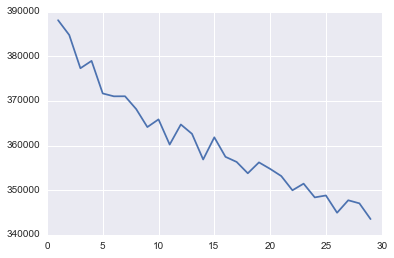

In [207]:
plot(range(1,30), inertia_list)

In [199]:
kc_predict = model.predict(vecs_bible)

/Users/Ben/anaconda/anaconda/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:862: RuntimeWarning: Got data type int64, converted to float to avoid overflows
  X = self._check_test_data(X)


In [204]:
kc_predict[2:100]  #first 20 docs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 8, 0, 2, 0, 0, 7, 2, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2,
       7, 2, 8, 2, 0, 0, 2, 2, 7, 0, 2, 0, 0, 3, 2, 2, 0, 0, 2, 1, 2, 1, 1,
       1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 8, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 1], dtype=int32)

In [200]:
distances = model.transform(vecs_bible)
distances[0] #will tell you, by cluster, how close a given doc is

/Users/Ben/anaconda/anaconda/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:836: RuntimeWarning: Got data type int64, converted to float to avoid overflows
  X = self._check_test_data(X)


array([  2.59837443,   2.53925145,   2.25917279,   2.63333849,
        36.95943723,   2.17993225,  70.01428426,   3.64544025,   2.62698645])

In [202]:
#sorting in descending order ie: -1
#giving top ten words ie: :10
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(9):
    print "Cluster %d:" % i,
    for ind in order_centroids[i, :10]:
        print ' %s' % terms[ind],
    print

Top terms per cluster:
Cluster 0:  god  lord  hath  man  us  o  israel  people  jesus  also
Cluster 1:  lord  hath  saith  o  people  israel  house  moses  day  man
Cluster 2:  man  came  also  come  men  people  went  shalt  let  hath
Cluster 3:  children  son  israel  lord  land  came  moses  house  man  men
Cluster 4:  sons  brethren  twelve  twentieth  weretwelve  hisbrethren  hissons  thefifth  thirteenth  one
Cluster 5:  king  israel  came  son  lord  house  judah  saying  david  people
Cluster 6:  son  wasthe  theson  sonof  juda  whichwas  ofjoseph  levi  joseph  began
Cluster 7:  lord  god  saith  israel  hath  house  saying  thus  land  people
Cluster 8:  one  every  another  offering  man  two  lord  day  even  come


In [ ]:
#preprocessing
document = [word for sublist in document for word in sublist]
                document = ' '.join(document)
                word_list = document.split()
                document = ' '.join([word for word in word_list if word not in stopwords])
                #                 document_revised = []
                #                 for i in document:
                #                     words = i.split()
                #                     for word in words:
                #                         if word not in stopwords:
                #                             document_revised.append(word)
                document = [re.sub(r'\W+', '', word) for word in document]
                document = [word for word in document if word.isalpha()]
                document = [word.lower() for word in document]
                texts.append(document)

In [55]:
document = [['blurpity blurp, blurp blurp blurp, 0.'], ['how do you do?'], 
            ['May I take the hat, Sir. May I take your hat, Sir!?']]

In [56]:
document = [word for sublist in document for word in sublist]
document = ' '.join(document)
word_list = document.split()
document = ' '.join([word for word in word_list if word not in stopwords])

# sentence = 'word1 word2 word3 word1 word2 word4'
# >>> remove_list = ['word1', 'word2']
# >>> word_list = sentence.split()
# >>> ' '.join([i for i in word_list if i not in remove_list])
# 'word3 word4'

# if word in stopwords, remove word from 
# document = [word for word in document.split() if word not in stopwords]
print document

#document = [sublist.split() for sublist in document]
#document = [word for word in sublist if word not in stopwords for sublist in document]
#document = [word for sublist in document for word in sublist]

# document_revised = []
# for i in document:
#     for word in i.split():
#         if word not in stopwords:
#             document_revised.append(word)
# print document_revised
# document_revised = [re.sub(r'\W+', '', word) for word in document_revised]
# document_revised = [word for word in document_revised if word.isalpha()]
# document_revised = [word.lower() for word in document_revised]
# print document_revised

blurpity blurp, blurp blurp blurp, 0. do? May I take hat, Sir. May I take hat, Sir!?


In [447]:
single_string = ''
for words in document:
    single_string += words + ' '
print single_string

blurpity blurp, blurp blurp blurp, 0. how do you do? may i take your hat, sir. may i take your hat, sir!? 
['blurpity blurp, blurp blurp blurp, 0.', 'how do you do?', 'may i take your hat, sir. may i take your hat, sir!?']


In [438]:
for i in document:
    print i.split()
    #for word in i:
    #    print word

['blurpity', 'blurp,', 'blurp', 'blurp', 'blurp,', '0.']
['how', 'do', 'you', 'do?']
['may', 'i', 'take', 'your', 'hat,', 'sir.', 'may', 'i', 'take', 'your', 'hat,', 'sir!?']


In [ ]:
#document = [word.lower() for word in document]
# remove stopwords and non-letters
#document = [re.sub(r'\W+', '', word) for word in document
#            if word.isalpha() and word not in stopwords]
corpus_by_sentence.append(document)


In [337]:
###Possible Params:
# filename
# format='gutenberg' --> controls start and end strs
# stemming='lancaster', 'porter', etc.
# min_freq=None, 2, etc.
# max_freq=None, 100, 1000, etc.
#lower=True  --> lowercase or not /alternately, capitalized=


bible = open('bible.txt')

startline = 100
endline = 1000000
verse = []
#user can specify stemming or not; if stemming, can say 'porter' or 'lancaster'
#unstemmed_verses = []
#stemmed_verses = []
#user can specify min_freq=None, or a number
min_freq = 2
#could do same for max_freq, and keep most popular words in a different place
stopwords = set(nltk.corpus.stopwords.words('english'))
#specify capitalized or not
capitalized = []

for i, line in enumerate(bible):
    if start in line:
        startline = i
    if end in line:
        endline = i
    if i > startline and i < endline:
        if line.strip():   # returns false if blank line
                           # this constitutes the BEGINNING OF A DOCUMENT.
            verse.append(line)

        
        else:  # end of verse
               # this constitutes the END OF A DOCUMENT.
            if len(verse) > 0 and isinstance(verse[0], str):
                # render lowercase and tokenize
                #verse = [line.lower() for line in verse]
                verse = [line.split() for line in verse]  
                # remove stopwords and non-letters
                new_verse = []
                for line in verse:
                    for word in line:
                        word = re.sub(r'\W+', '', word)  
                        if word.isalpha() and word not in stopwords:
                            new_verse.append(word)
                
                #stem down, if wanted
                #stemmer = nltk.stem.porter.PorterStemmer()
                #stemmer = nltk.stem.lancaster.LancasterStemmer()
                #stemmed_verse = [stemmer.stem(word) for word in new_verse]
                
                capitalized.append(new_verse)
                #unstemmed_verses.append(new_verse)
                #stemmed_verses.append(stemmed_verse)
                ###eventually, for mongo: bible.save(verse)
                verse = []

#Future optimization: stemming (this works, just dont want to do until further modularized)
# # remove words that appear less than a minimum frequency, if wanted
# frequency = defaultdict(int)
# for document in verses:
#     for token in document:
#         frequency[token] += 1
# verses = [[token for token in document if frequency[token] >= min_freq] 
#            for document in verses]
        
bible.close()

In [ ]:
#str.isalpha()
#re.sub(r'\W+', '', word)   
#THIS PART WAS SPECIFIC TO THE BIBLE    
#if re.match(r'\b\d{1,3}[:]\d{1,2}\b', line):   # new verse
#    verse = [line]
#else:
#   verse.append(line)

In [219]:
#our corpuses:
corp = unstemmed_verses
stemmed_corp = stemmed_verses
unstemmed_verses[0], stemmed_verses[0]

(['old', 'testament', 'king', 'james', 'version', 'bible'],
 ['old', 'testa', 'king', 'jam', u'vert', 'bibl'])

In [338]:
capitalized[0]

['The', 'Old', 'Testament', 'King', 'James', 'Version', 'Bible']

In [241]:
with open('bible_corpus_stemmed.pkl', 'w') as picklefile:
    pickle.dump(stemmed_verses, picklefile)
with open('bible_corpus_unstemmed.pkl', 'w') as picklefile:
    pickle.dump(unstemmed_verses, picklefile)

#2. preliminary exploration

###2a. part of speech tagging

In [349]:
from nltk.tag import pos_tag  #takes about 5 mins
#pos_tag_words = [pos_tag(doc) for doc in tqdm(corp)]

In [351]:
w = 'hello'
pos_tag(w)

LookupError: 
**********************************************************************
  Resource u'taggers/averaged_perceptron_tagger/averaged_perceptro
  n_tagger.pickle' not found.  Please use the NLTK Downloader to
  obtain the resource:  >>> nltk.download()
  Searched in:
    - '/Users/Ben/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

In [348]:
pos_tag_incl_capitals = [pos_tag(doc) for doc in tqdm(capitalized)]

NameError: name 'capitalized' is not defined

In [343]:
pos_tag_incl_capitals[0]

[('The', 'DT'),
 ('Old', 'NNP'),
 ('Testament', 'NNP'),
 ('King', 'NNP'),
 ('James', 'NNP'),
 ('Version', 'NNP'),
 ('Bible', 'NNP')]

In [240]:
# import pickle
# with open('bible_words_by_part_of_speech.pkl', 'w') as picklefile:
#     pickle.dump(pos_tag_words, picklefile)

In [342]:
with open('bible_words_by_part_of_speech.pkl', 'w') as picklefile:
    pickle.dump(pos_tag_incl_capitals, picklefile)

In [244]:
def get_pos_popularity(corp):
    pos_popularity = defaultdict(int)
    for doc in corp:
        for word, pos in doc:
            pos_popularity[pos] += 1
    return pos_popularity

In [245]:
#pos_popularity = get_pos_popularity(pos_tag_words)
#bad b/c doesn't include proper nouns!

In [340]:
pos_popularity_with_capitals = get_pos_popularity(pos_tag_incl_capitals)

In [341]:
pos_popularity_with_capitals

defaultdict(<type 'int'>, {'PRP$': 752, 'VBG': 7344, 'VBD': 29964, 'VBN': 12029, 'VBP': 15202, 'WDT': 227, 'JJ': 18432, 'WP': 519, 'VBZ': 2231, 'DT': 5519, 'RP': 284, 'NN': 129122, 'TO': 164, 'PRP': 13525, 'RB': 16367, 'NNS': 36531, 'NNP': 56326, 'VB': 13814, 'WRB': 646, 'CC': 14547, 'PDT': 8, 'RBS': 1, 'RBR': 112, 'CD': 4983, 'EX': 204, 'IN': 21777, 'WP$': 279, 'MD': 11220, 'NNPS': 454, 'JJS': 622, 'JJR': 641, 'UH': 12})

In [263]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

#I JUST WANT TO MAKE A FUCKING SIMPLE BAR CHART AND IT'S FUCKING ANNOYINGLY HARD TO DO SO

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [282]:
# sns.countplot(y="party", hue="party", data=reps_df)
# sns.plt.show()

In [262]:
pos_dict = {
'CC': 'coordinating conjunction---etc',
'CD': 'cardinal number---1, third',
'DT': 'determiner (article)---the, a, an',
'EX': 'existential there---there is',
'FW': 'foreign word---d’hoevre',
'IN': 'preposition/subordinating conjunction---in, of, like',
'JJ': 'adjective---big',
'JJR': 'adjective, comparative---bigger',
'JJS': 'adjective, superlative---biggest',
'LS': 'list marker---1)',
'MD': 'modal (subjunctive)---could, will',
'NN': 'noun, singular or mass---door',
'NNS': 'noun plural---doors',
'NNP': 'proper noun, singular---John',
'NNPS': 'proper noun, plural---Vikings',
'PDT': 'predeterminer---both the boys',
'POS': 'possessive ending---friend‘s',
'PRP': 'personal pronoun---I, he, it',
'PRP$': 'possessive pronoun---my, his',
'RB': 'adverb---however, usually, naturally, here, good',
'RBR': 'adverb, comparative---better',
'RBS': 'adverb, superlative---best',
'RP': 'particle---give up',
'TO': 'to---to go, to him',
'UH': 'interjection---uhhuhhuhh',
'VB': 'verb, base form---take',
'VBD': 'verb, past tense---took',
'VBG': 'verb, gerund/present participle---taking',
'VBN': 'verb, past participle---taken',
'VBP': 'verb, sing. present, non-3d---take',
'VBZ': 'verb, 3rd person sing. present---takes',
'WDT': 'wh-determiner---which',
'WP': 'wh-pronoun---who, what',
'WP$': 'possessive wh-pronoun---whose',
'WRB': 'wh-abverb---where, when'
    }

###2b. sentiment analysis

In [257]:
# everything together as one string
flattened_corp = ''.join(str(corp).translate(None,"[]'").split(','))

In [259]:
TextBlob(flattened_corp).sentiment

Sentiment(polarity=0.12117085186315783, subjectivity=0.520236563826305)

In [429]:
overall_sentiment = {}
for i, b in enumerate(bibles_data):
    print i
    for name, corp in tqdm(b.items()):
        flattened = ' '.join(corp)
        overall_sentiment[name] = TextBlob(flattened).sentiment

0
1


2


3


4


5


6

In [431]:
for name, sentiment in overall_sentiment.items():
    print name
    print sentiment
    print '\n'

New International Version
Sentiment(polarity=0.05308589129172552, subjectivity=0.26887834650072606)


Hebrew Names Version
Sentiment(polarity=0.1120478882007661, subjectivity=0.507007798795785)


Good News Translation
Sentiment(polarity=0.07527512356919792, subjectivity=0.4450116209132388)


GOD'S WORD Translation
Sentiment(polarity=0.0671739959380672, subjectivity=0.48785011113700266)


King James Version
Sentiment(polarity=0.11447387185513332, subjectivity=0.5139551135032695)


The Darby Translation
Sentiment(polarity=0.1074006628663569, subjectivity=0.5030664198887135)


The Webster Bible
Sentiment(polarity=0.12066581270199164, subjectivity=0.5183539437574518)


Wycliffe
Sentiment(polarity=0.12039701686302584, subjectivity=0.4963956405280762)


The Bible in Basic English
Sentiment(polarity=0.05689191480548633, subjectivity=0.4983546374868515)


World English Bible
Sentiment(polarity=0.11072252151980345, subjectivity=0.506188593731399)


Douay-Rhiems Catholic Bible
Sentiment(polarity

In [423]:
#bibles_data[0]['American Standard Version']

###2c. word counts
idk where the fuck these come frome so ima do it up in gensim...

#3. stick it into gensim

In [398]:
model = models.Doc2Vec(corp, size=100, window=8, min_count=5, workers=4)

AttributeError: 'list' object has no attribute 'words'

###3a. token dictionary

In [298]:
# corpora = corp, stemmed_corp

In [296]:
#corp[10]

In [297]:
import logging
from gensim import corpora, models, similarities
#setting basic config
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#i would like to remove all proper nouns from the corpus...clearly not working...why?

In [380]:
corp_sans_proper_nouns = capitalized
for i, doc in enumerate(corp_sans_proper_nouns):
    for j, word in enumerate(doc):
        if pos_tag_incl_capitals[i][j][1] == 'NNP':
            corp_sans_proper_nouns[i].remove(word)

In [383]:
#pos_tag_incl_capitals[222]

In [362]:
corp_sans_proper_nouns = capitalized
for i, doc in enumerate(pos_tag_incl_capitals):
    for j, word_pos in enumerate(doc):
        if word_pos[1] == 'NNP':
            corp_sans_proper_nouns[i].remove(corp_sans_proper_nouns[i][j])

IndexError: list index out of range

In [299]:
#1. collect statistics about all tokens
dictionary = corpora.Dictionary(doc for doc in corp)

#2a. remove stop words and words that appear only once
# stop_ids = [dictionary.token2id[stopword] for stopword in stoplist
#             if stopword in dictionary.token2id]
once_ids = [tokenid for tokenid, docfreq in dictionary.dfs.iteritems() if docfreq == 1]

#2b. remove stop words and words that appear only once
dictionary.filter_tokens(once_ids)  # + stop_ids

#3. remove gaps in id sequence after words that were removed
dictionary.compactify() 


# #The shorter way
# dictionary = corpora.Dictionary(texts)
# dictionary.save('deerwester.dict') # store the dictionary, for future reference
# print(dictionary)

In [305]:
print dictionary
#mapping between words : IDs
#print(dictionary.token2id)

Dictionary(8448 unique tokens: [u'giddel', u'yellow', u'four', u'aijalon', u'spiders']...)


###3b. vectorized corpus
The function `doc2bow()` simply counts the number of occurences of each distinct word, converts the word to its integer word id and returns the result as a sparse vector.
The sparse vector therefore reads: in the document “Human computer interaction”, the words computer (id 1) and human (id 2) appear once; the other ten dictionary words appear (implicitly) zero times.

In [313]:
## Memory-Friendly Streaming
# class MyCorpus(object):
#     def __iter__(self):
#         for line in open('mycorpus.txt'):
#             # assume there's one document per line, tokens separated by whitespace
#             yield dictionary.doc2bow(line.lower().split())

# corpus_memory_friendly = MyCorpus() # doesn't load the corpus into memory!
# print(corpus_memory_friendly)

In [308]:
vec_corp = [dictionary.doc2bow(doc) for doc in corp]

In [311]:
vec_corp[222]

[(653, 2),
 (2717, 2),
 (3331, 1),
 (3459, 2),
 (3976, 3),
 (5199, 1),
 (5279, 1),
 (6709, 2),
 (7392, 1),
 (7734, 1)]

In [312]:
dictionary[3976]

u'begat'

###3c. modeled transformations

####Term Frequency / Inverse Document Frequency (tf-idf)
I think would do better w/o proper nouns. (De)capitalization probs doesn't matter either, so can use the `capitalized` corpus.

In [314]:
tfidf = models.TfidfModel(vec_corp) # -- initialize (train) a model
corpus_tfidf = tfidf[vec_corp]
# for doc in corpus_tfidf:  #streamed on-the-fly
#     print doc

In [317]:
#corpus_tfidf[222]

In [333]:
max_tfidf = [(0, 0)]
for doc in corpus_tfidf:
    for term in doc:
        current_max = max_tfidf[0][1]
        if term[1] > current_max:
            max_tfidf[0] = term
        if term[1] == 1.0 and term not in max_tfidf:
            max_tfidf.append(term)

In [334]:
len(max_tfidf) #all these got 1.0

20

In [335]:
for term_id, _ in max_tfidf:
    print dictionary[term_id]

son
ezra
selah
proverbs
preacher
hosea
joel
amos
obadiah
jonah
micah
nahum
habakkuk
zephaniah
haggai
zechariah
malachi
lord
amen
despise


In [336]:
# may want to remove all NNP, all proper nouns...

####Latent Semantic Indexing (LSI)
So,
- remove proper nouns.

also,
- get rid of the 'formal' stopwords like shall, thy, thou, thee, ye, thine, said, hast, unto, upon... these are really clogging things up

In [390]:
# initialize an LSI transformation
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=6) 

# create a double wrapper over the original corpus: 
# bow --> tfidf --> fold-in-lsi
corpus_lsi = lsi[corpus_tfidf] 

In [391]:
lsi.print_topics(6)

[(0,
  u'0.284*"shall" + 0.243*"thou" + 0.243*"unto" + 0.243*"thy" + 0.242*"lord" + 0.222*"thee" + 0.182*"god" + 0.180*"said" + 0.178*"ye" + 0.129*"israel"'),
 (1,
  u'-0.488*"thy" + -0.458*"thou" + -0.294*"thee" + 0.289*"ye" + -0.278*"shalt" + 0.261*"shall" + -0.179*"hast" + 0.126*"israel" + -0.116*"thine" + 0.105*"children"'),
 (2,
  u'-0.619*"shall" + 0.261*"king" + -0.260*"ye" + 0.207*"israel" + 0.187*"son" + 0.178*"came" + 0.170*"said" + 0.151*"david" + 0.140*"went" + 0.133*"children"'),
 (3,
  u'-0.311*"ye" + 0.301*"shall" + 0.229*"shalt" + -0.197*"god" + -0.190*"said" + 0.175*"hundred" + 0.170*"children" + 0.159*"offering" + 0.155*"thousand" + -0.146*"us"'),
 (4,
  u'0.589*"thy" + -0.435*"thou" + -0.390*"shalt" + -0.177*"said" + 0.160*"o" + -0.141*"unto" + -0.106*"ye" + -0.100*"hast" + -0.097*"jesus" + 0.091*"lord"'),
 (5,
  u'0.380*"children" + -0.331*"king" + 0.297*"israel" + 0.284*"moses" + 0.231*"lord" + -0.216*"shall" + 0.191*"ye" + -0.155*"son" + -0.152*"said" + 0.120*"aar

In [396]:
corp[0]
#well that's fucked. that's not supposed to happen. have to MODULARIZE.

['old', 'version']

In [394]:
# transform corpus to LSI space and index it
index = similarities.MatrixSimilarity(lsi[corp], num_features=3) 

ValueError: too many values to unpack

#Next Steps: (for tomorrow [tues])

1. remove proper nouns.

2. get rid of the 'formal' stopwords like shall, thy, thou, thee, ye, thine, said, hast, unto, upon... these are really clogging things up

3. ~modularize~

4. try with stemmed corpus!

still have to try

5. lda (& pca?)
6. hdp
7. w2v

and then

8. PCA & KNN(++)

In [ ]:
Preliminary Stopwords List:

shall, thy, thou, thee, ye, thine, said, hast, unto, upon
shant, 

#sklearn

In [577]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances

text = [line for line in open('bible.txt').readlines()]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(text)

X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
pairwise_distances(X, Y=None, metric='cosine')

In [ ]:
pairwise_distances(X, Y=None, metric='euclidean')

In [ ]:
import numpy as np
X = X.toarray()
np.corrcoef(X)